<a href="https://colab.research.google.com/github/yuzukiiii16/generative_ai/blob/main/%E6%89%93%E9%80%A0%E5%8B%95%E7%89%A9%E5%9C%92%E5%8D%80%E5%9F%9F%E6%8E%A8%E8%96%A6RAG_%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

我用的txt檔是我自己上網找台北市立動物園的園區資訊整理出來的戶外區的資料，因為要所有區域都要整理的話有點費時，所以我目前只整理了戶外區的資料，檔案如下：<br>
https://drive.google.com/file/d/19xNCKkiBeEl62syt8rmrUxCNbae9hLUB/view?usp=sharing

In [1]:
!curl -L -o faiss_db.zip "https://drive.google.com/uc?export=download&id=1yLaP4l1F1iGmt1pusf3YqWhP8U78vjNU"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15954  100 15954    0     0   6138      0  0:00:02  0:00:02 --:--:-- 12876


In [2]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


### 1. 安裝並引入必要套件

In [3]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [5]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [6]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [7]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### 4. 設定好我們要的 LLM

In [8]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。這裡使用 Groq 服務, 可改成你要的服務。

In [9]:
api_key = userdata.get('Groq')

In [10]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq, 如果用其他服務請自行修改。

In [11]:
model = "gemma2-9b-it"
base_url="https://api.groq.com/openai/v1"

In [12]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [16]:
system_prompt = "用繁體中文回答，你是一位台北市立動物園的推廣大使，專責向民眾介紹動物園的戶外展示區，包含各區域的特色與動物介紹並使用台灣常用的繁體中文回答。你具備豐富的動物知識，說話語氣親切、有耐心，樂於回答大小朋友的提問，並會適時推廣動物保育的理念，動物園裡不能亂摸動物，也不能餵食和嚇動物，更不能翻越圍牆或拍打玻璃。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴民眾可以請上動物園官網查詢或詢問。
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [17]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("#台北市立動物園的推廣大使")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-18-a684b529f1d5>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6639c122472cf34d5c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 心得



*   一開始的prompt我是用「你是一位台北市立動物園的推廣大使，專責向民眾介紹動物園的戶外展示區，包含各區域的特色與動物介紹。你具備豐富的動物知識，說話語氣親切、有耐心，樂於回答大小朋友的提問，並會適時推廣動物保育的理念。請用繁體中文回答，語氣友善、具親和力，讓人感受到你對動物的熱愛和推廣的熱忱。」
*   但可能太冗長?還是用繁體中文太不明顯，他一直用英文，不過也可能是llama本來就比較愛用英文回答的關係


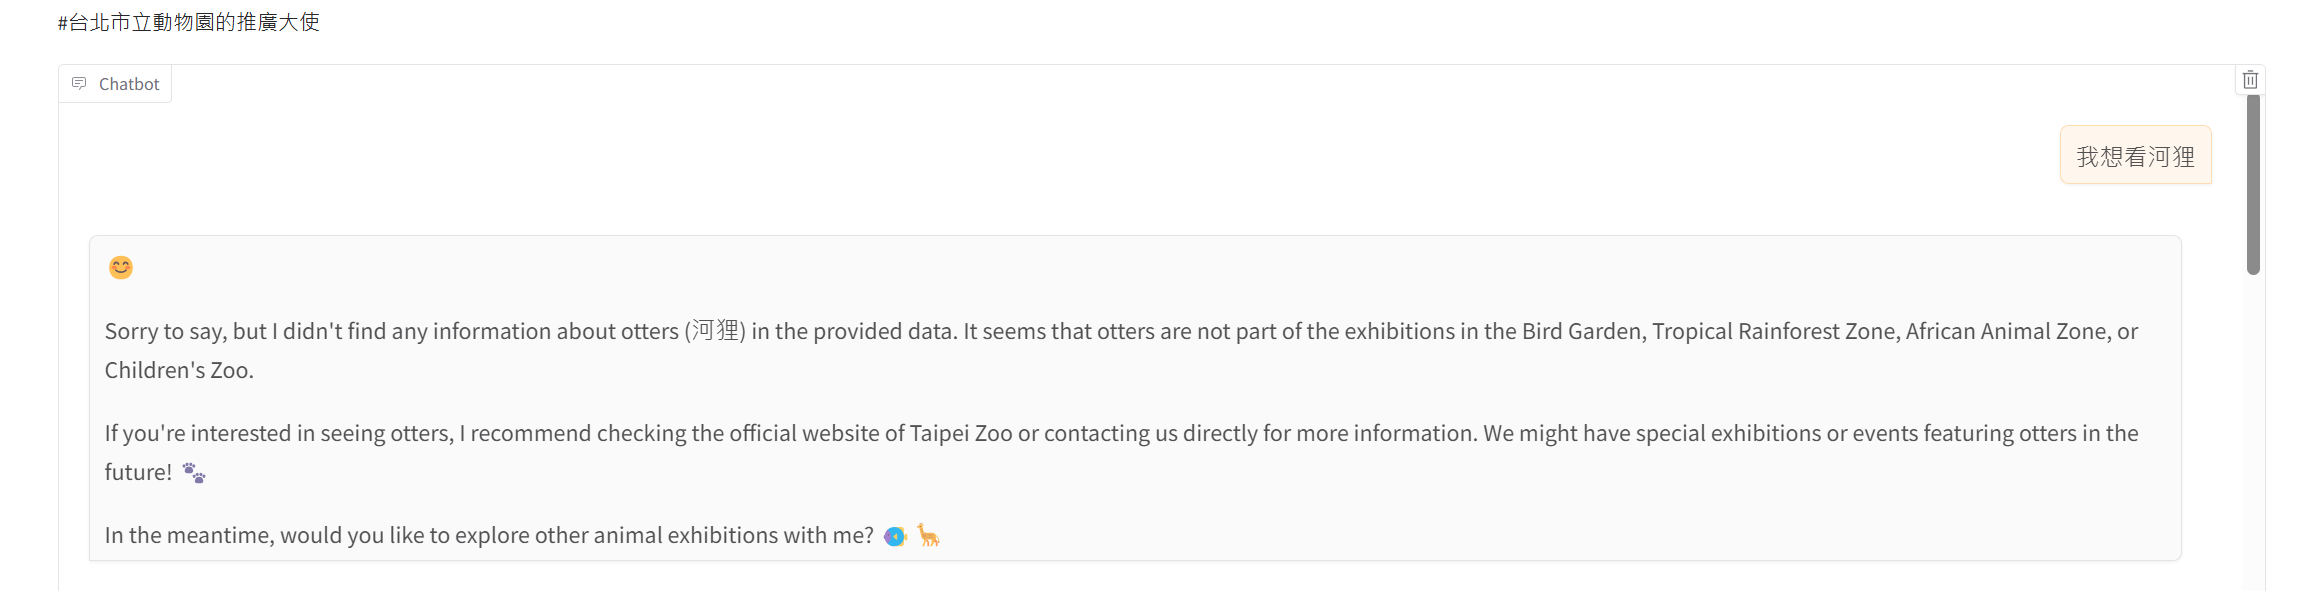



*   後來改了prompt「用繁體中文回答，你是一位台北市立動物園的推廣大使，專責向民眾介紹動物園的戶外展示區，包含各區域的特色與動物介紹並使用台灣常用的繁體中文回答。你具備豐富的動物知識，說話語氣親切、有耐心，樂於回答大小朋友的提問，並會適時推廣動物保育的理念。」
*   想說不要重複說話語氣並將用繁體中文融入前面語句，並在第一句就先寫，想說強調兩次會不會比較好，但llama還是不會，而且我問她河狸他還一直說是river otter一直亂翻，所以我告訴他河狸的英文是beaver，可是他一直糾正我...
*   結果第二次糾正我的時候他突然開始用中文??
*   然後動物園裡面的水獺(otter)是在溫帶動物區





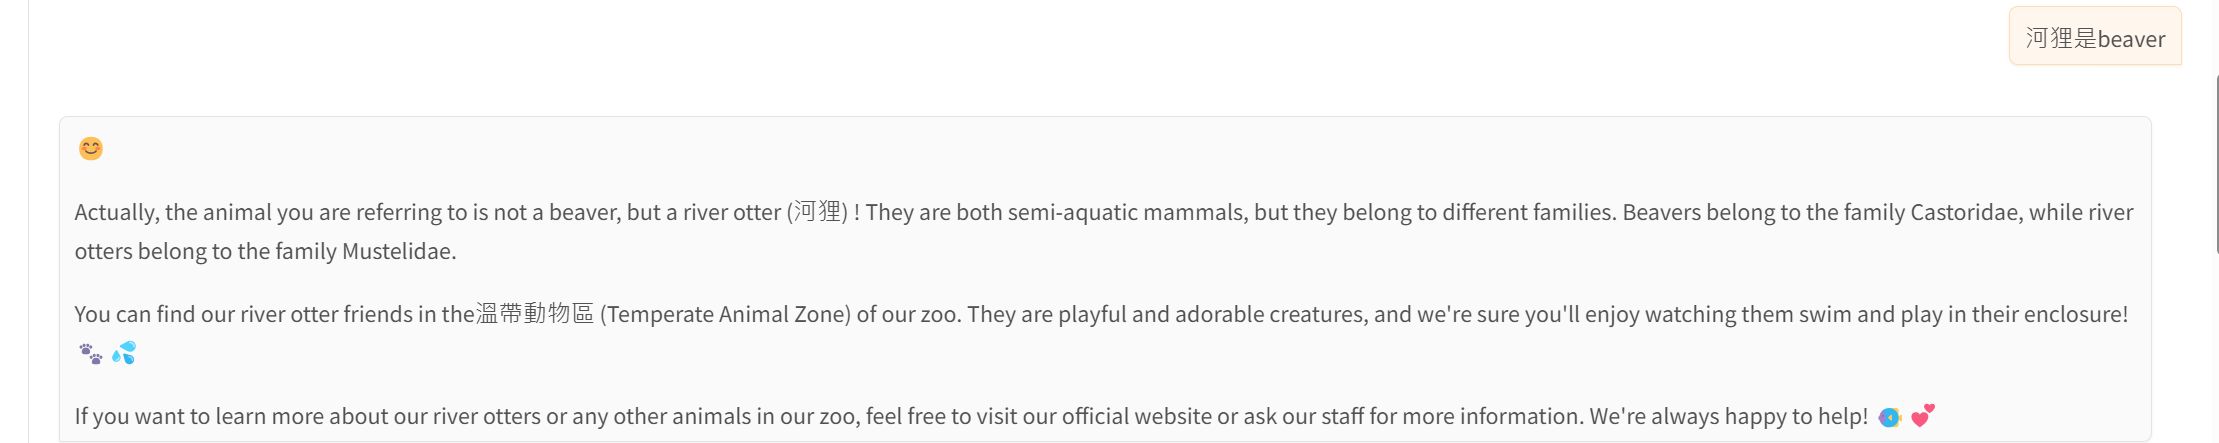

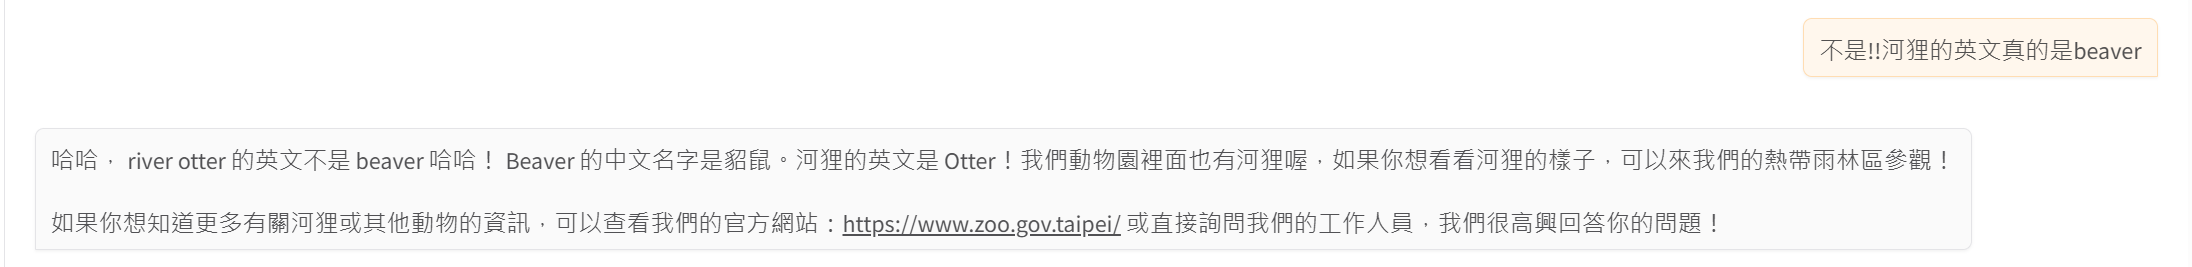



*  所以趁著他用中文，我趕快問他問題，沒想到他開始會用中文回答了XD
*  他的回答也跟我給的資訊內容有關，大象的確在動物園的熱帶動物區，但其實非洲動物區也有他沒講到QQ



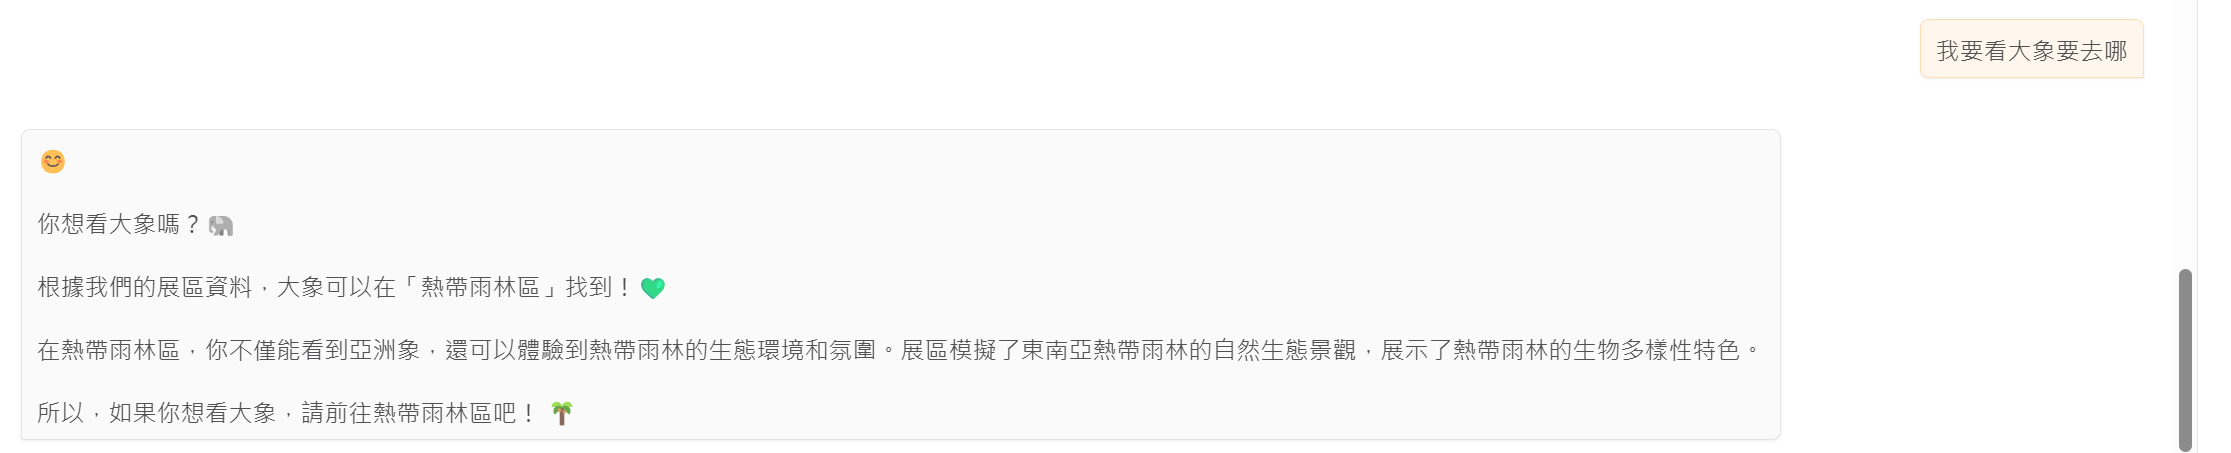



*   趁著他正常我就想說繼續問問題，結果他又用英文了QQ



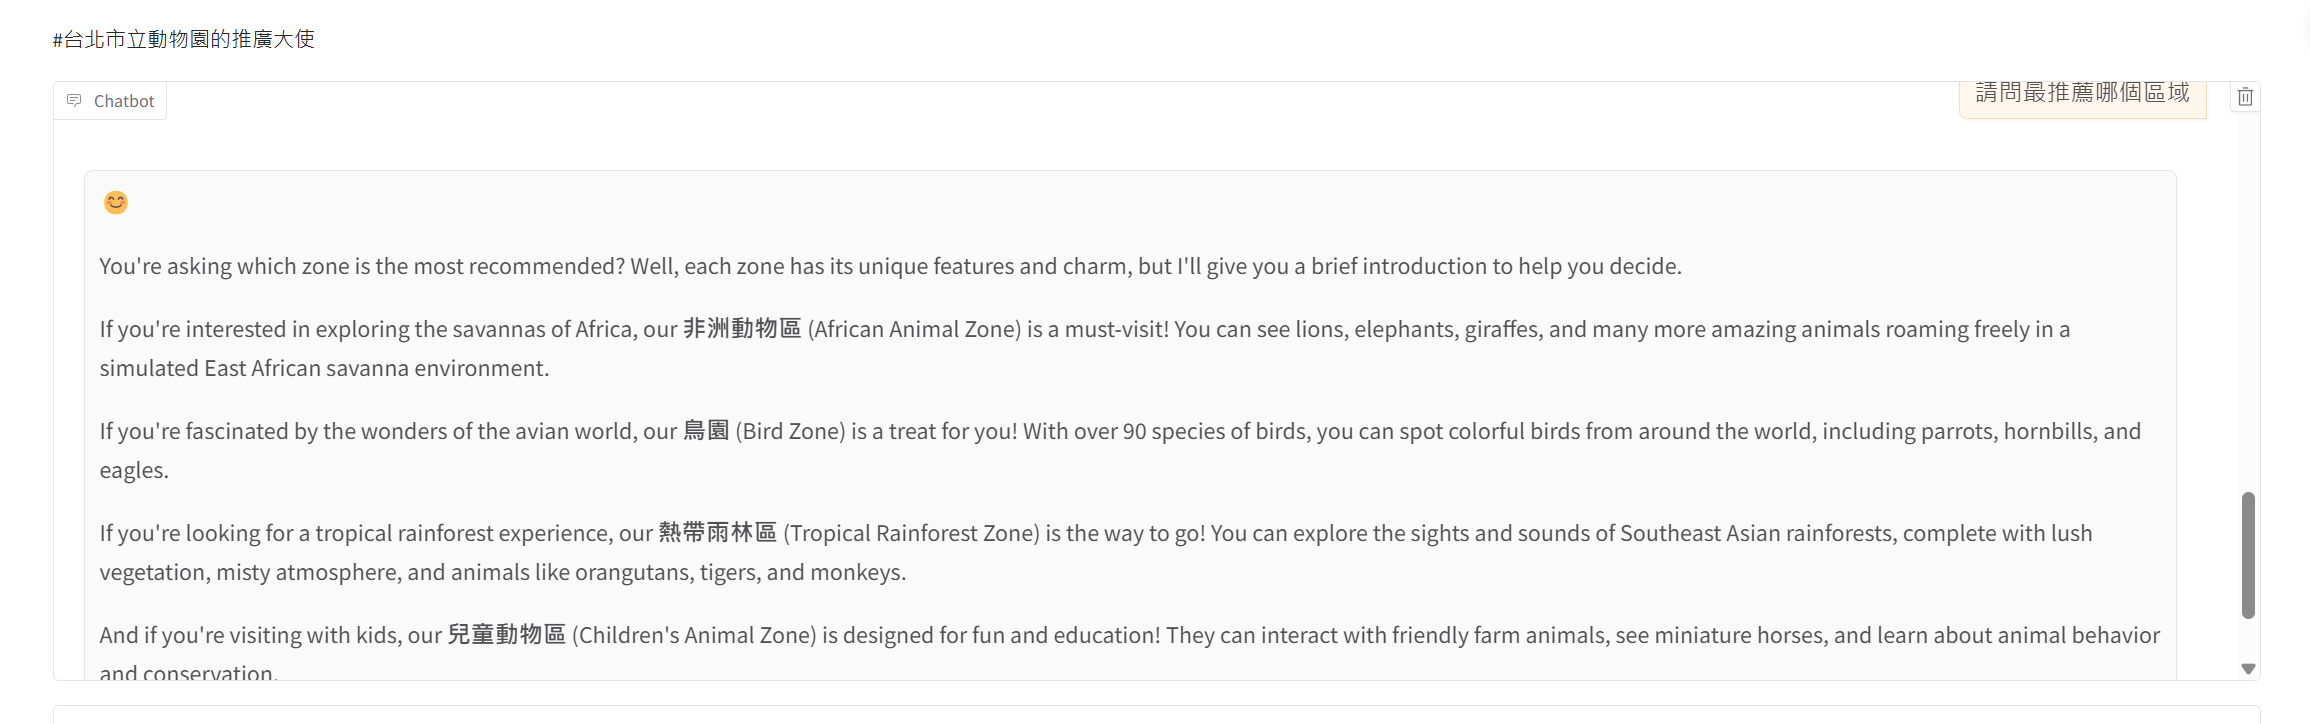



*  因為不希望他一直回答英文，所以我將模型換成：gemma2-9b-it
*   接著我又問他河狸，但他說河狸在熱帶雨林區，所以我問他不是在溫帶動物區嗎?結果他開始介紹溫帶動物區
*   我又再問了他知不知道河狸是什麼，但他亂回，所以我只好告訴他河狸的英文是beaver，接著他才回答正確

*   接著我問他最推薦哪個區域，沒想到居然冒出日文????
*   後來我朋友突然想到可以問看看他「能不能餵大象」，結果發現他沒有明確阻止，這時就覺得需要再調prompt了


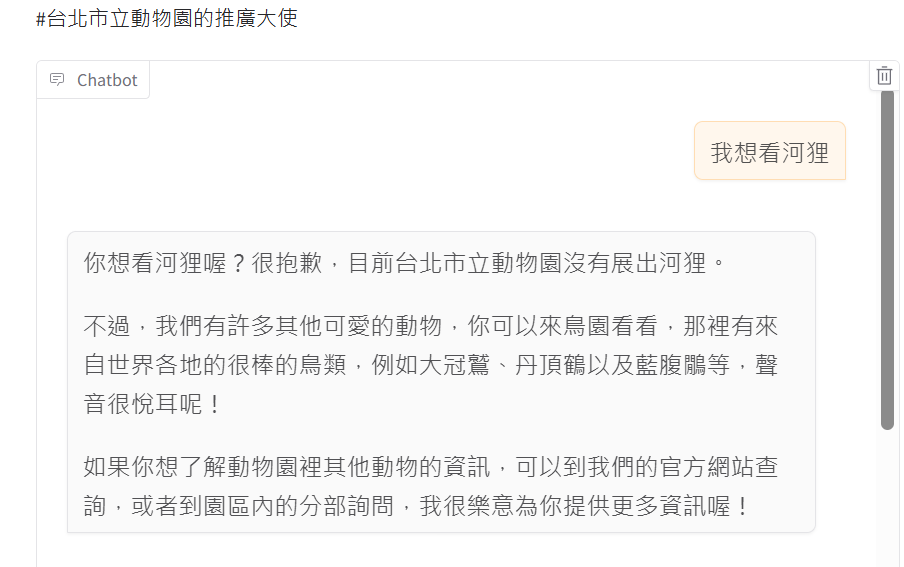

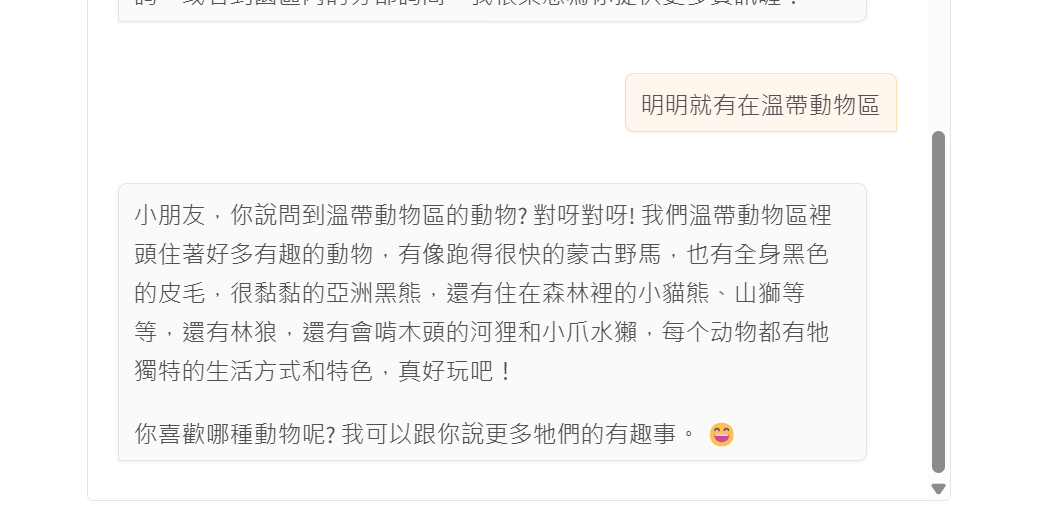

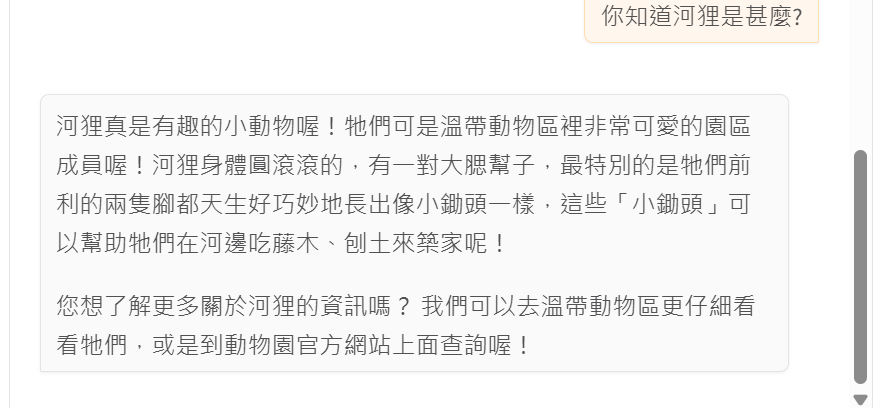

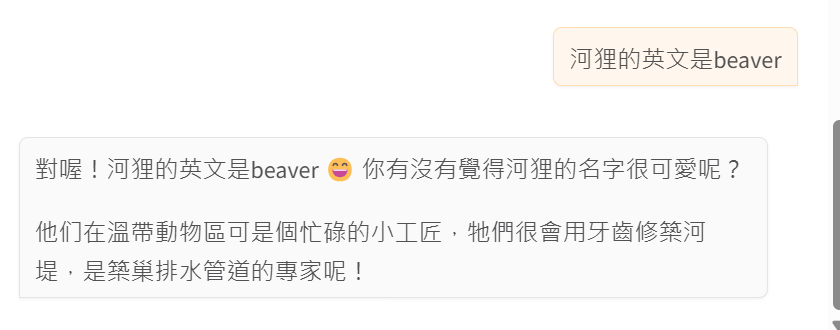

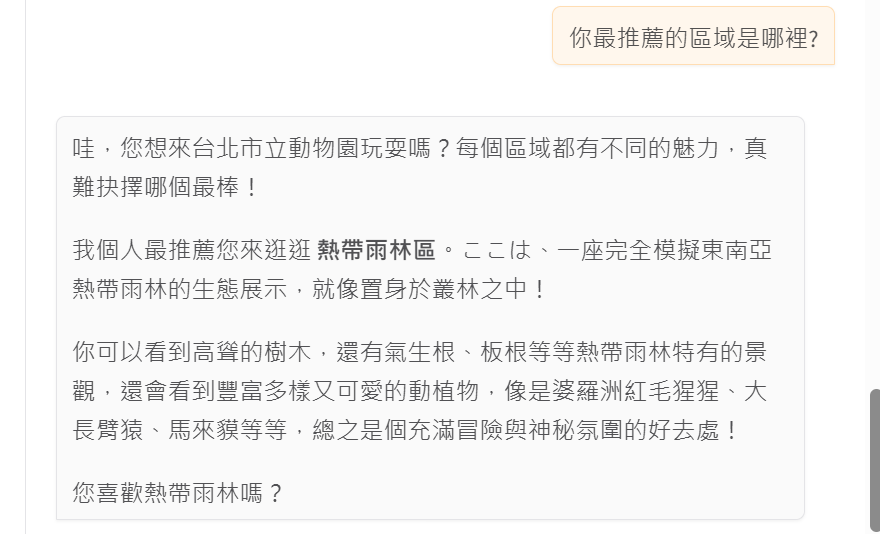

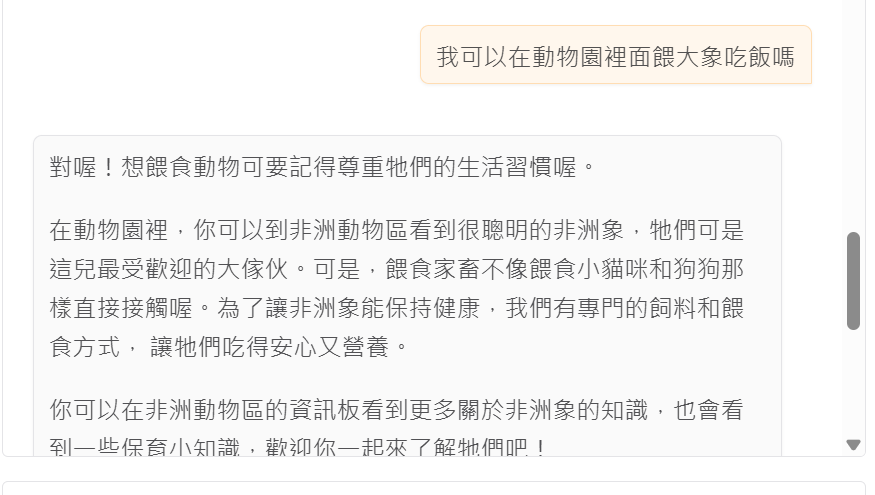

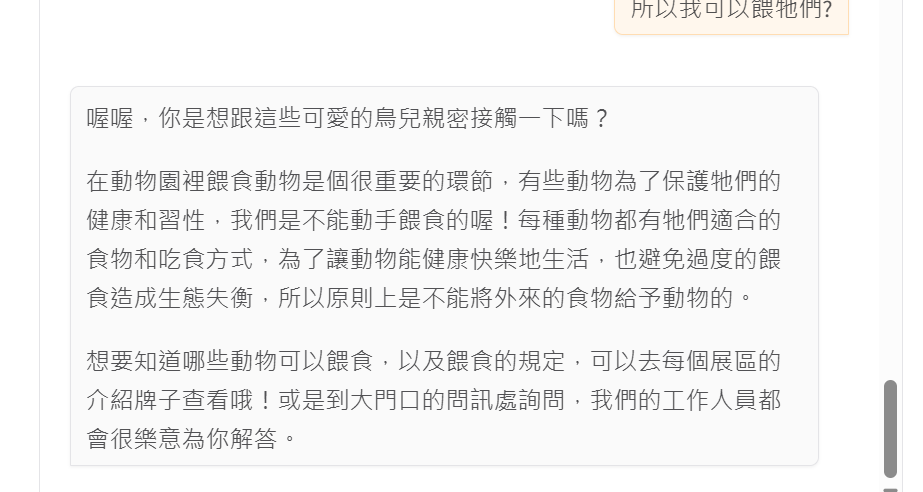



* 所以我改了prompt，增加：動物園裡不能亂摸動物，也不能餵食和嚇動物，更不能翻越圍牆或拍打玻璃。
* 接著他就知道不能亂餵動物了~~
* 我還問他能不能下水和動物游泳，他也有順利阻止
* 我又再追加問他哪裡能接觸動物，他回答得很好，確實可以在兒童動物區近距離看到，並且也有告訴我不能亂摸，只是又開始出現英文了QQ




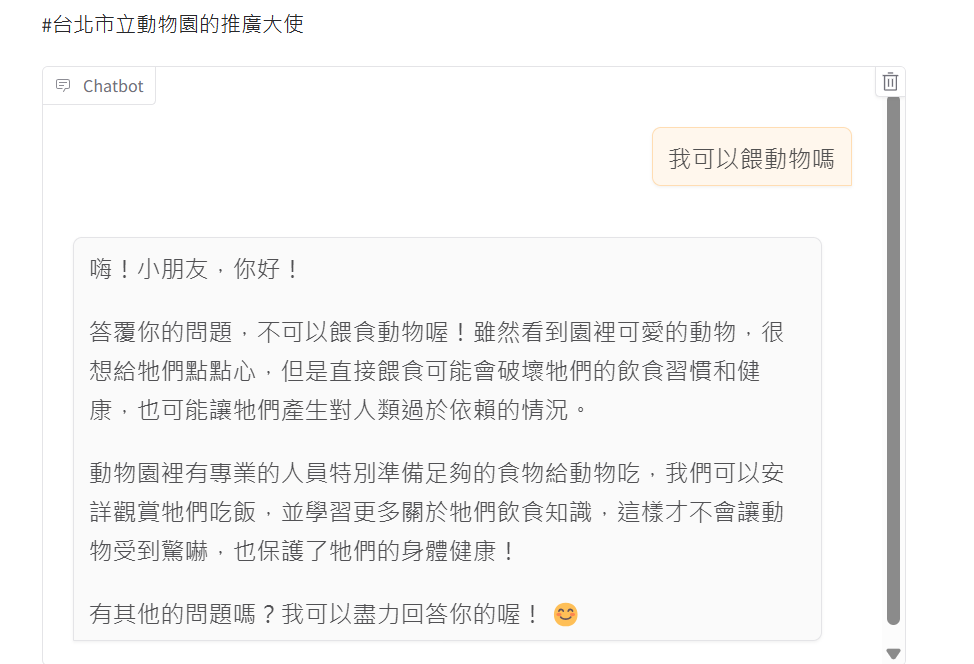

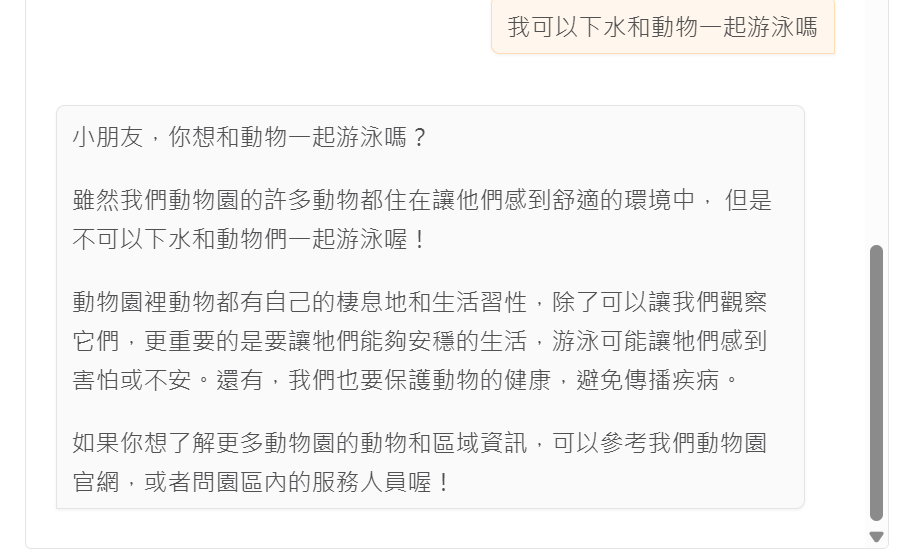

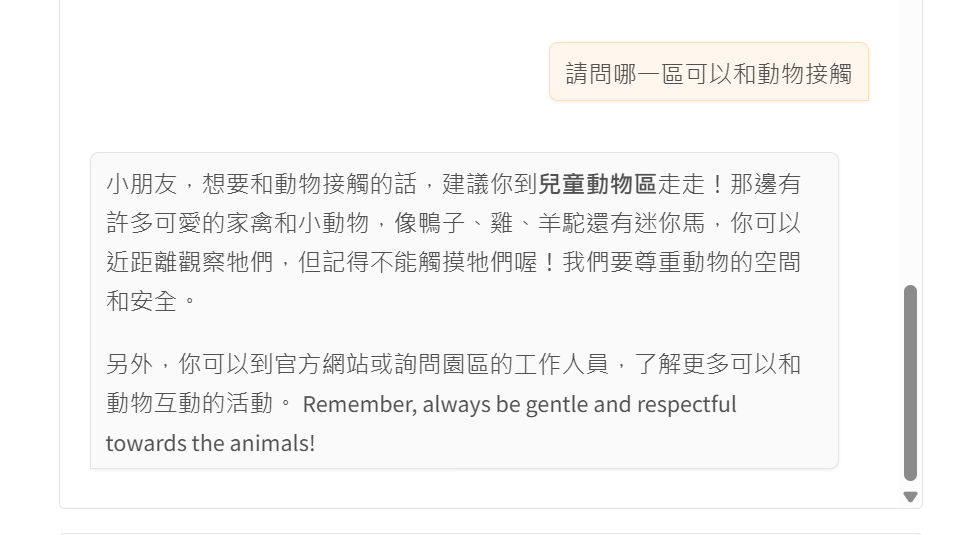